In [4]:
import pandas as pd
import numpy as np

import data
import util

In [5]:
daily = data.get_transit_daily()

In [6]:
# gets a smaller version for faster troubleshooting
daily = daily.head(10000)
daily = daily.dropna(axis=0, subset=["service_date", "arrival_time"])
daily = daily.sort_values(["service_date", "arrival_time"])

In [7]:
daily["timestamp"] = np.vectorize(util.to_timestamp)(
    daily["service_date"], daily["arrival_time"]
)

In [8]:
daily = daily.sort_values(["trip_id", "timestamp"])

In [9]:
daily.deviance = daily.deviance.apply(lambda x: pd.to_timedelta(x).total_seconds())

In [10]:
int_types = [
    "trip_id",
    "arrival_time",
    "departure_time",
    "stop_time",
    "door",
    "gtfs_trip_id",
    "gtfs_stop_time_id",
    "stop_id",
    "trip_number",
    "route_number",
    "vehicle_number",
    "deviance",
]
daily[int_types] = daily[int_types].fillna(0).astype("int32")

In [11]:
daily["secs_stopped"] = daily.departure_time - daily.arrival_time

minutes_per_time_cat = 5
daily["time_cat"] = (daily.arrival_time % (60 * 60 * 24))  // 60 // minutes_per_time_cat

In [12]:
categories = [
    "trip_number",
    "gtfs_stop_time_id",
    "gtfs_stop_id",
    "gtfs_trip_id",
    "train",
    "trip_id",
    "data_agency",
    "data_source",
    "direction",
    "schedule_status",
    "service_key",
    "stop_id",
    "vehicle_number",
    "route_number",
    "trip_number",
    "time_cat",
    "door",
]

# should work from what I understand, but doesn't...
# daily[categories] = daily[categories].astype("category")

util.make_categories(categories, daily)

In [13]:
dist = ["pattern_distance", "train_mileage"]
delta_dist = ["delta_" + x for x in dist]

daily[delta_dist] = daily[dist].diff(1)

daily[delta_dist] = np.where(daily[delta_dist] < 0, 0, daily[delta_dist])

In [14]:
daily["avg_speed"] = daily.delta_pattern_distance / (
    daily.arrival_time - daily.departure_time.shift(1)
)

In [15]:
daily.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
arrival_time,10000.0,4.995051e+04,16966.188808,16039.00,36167.250000,48458.000000,61726.250000,93862.00
departure_time,10000.0,4.996756e+04,16966.068905,16039.00,36200.500000,48485.500000,61743.250000,93862.00
lift,10000.0,7.300000e-03,0.092992,0.00,0.000000,0.000000,0.000000,2.00
ons,10000.0,3.882000e-01,1.071175,0.00,0.000000,0.000000,0.000000,20.00
offs,10000.0,3.773000e-01,1.079565,0.00,0.000000,0.000000,0.000000,41.00
estimated_load,10000.0,6.691400e+00,6.493457,0.00,0.000000,6.000000,11.000000,31.00
capacity,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
early,10000.0,0.000000e+00,0.000000,0.00,0.000000,0.000000,0.000000,0.00
on_time,10000.0,0.000000e+00,0.000000,0.00,0.000000,0.000000,0.000000,0.00
late,10000.0,0.000000e+00,0.000000,0.00,0.000000,0.000000,0.000000,0.00


In [16]:
empty_cols = [
    "early",
    "on_time",
    "late",
    "location_distance",
    "capacity",
]
daily = daily.drop(axis=1, columns=empty_cols)


In [17]:
daily['label'] = daily.deviance.shift(-5) # making a prediction from 5 stops previously.

In [18]:
daily = daily[~daily.isin([np.nan, np.inf, -np.inf]).any(1)]

In [19]:
used_cols = [
    "direction",
    "door",
    "lift",
    "dwell",
    "ons",
    "offs",
    "maximum_speed",
    "service_key",
    "schedule_status",
    "deviance",
    "secs_stopped",
    "time_cat",
    "stop_id",
    "delta_pattern_distance",
    "avg_speed",
    "label",
]
x = daily[used_cols]
x = pd.get_dummies(x)  # turns all categoricals into one hot encoded columns!
label = x.pop("label")

In [20]:
print("number of input features: ", len(sorted(x)))

number of input features:  448


In [46]:
from sklearn.decomposition import PCA

pca = PCA(10)

In [53]:
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def train_svm(data, targets):
  regr = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5))
  return regr.fit(data, targets)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x.values, label.values)

proj = pca.fit_transform(X_train)
test_proj = pca.transform(X_test)
print("variance ratio: ", pca.explained_variance_ratio_)
print("sum of variance_ratio: ", np.sum(pca.explained_variance_ratio_))
print("shape of new data: ", proj.shape)

svm = train_svm(X_train, y_train)

variance ratio:  [9.94810002e-01 4.15428333e-03 8.35547809e-04 1.72991048e-04
 2.56990875e-05 1.30612170e-06 4.25971424e-08 3.06747932e-08
 1.57523489e-08 8.49214785e-09]
sum of variance_ratio:  0.9999999267093583
shape of new data:  (7494, 10)


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [54]:
def test_svm(svm, data):
  return svm.predict(data)

results = test_svm(svm,X_test)

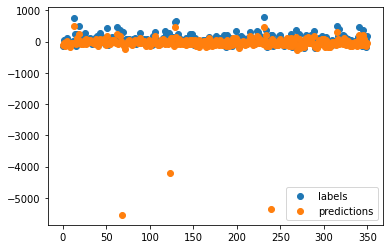

In [55]:
util.plot(69,420,results,y_test)